In [1]:
import numpy as np
import matplotlib
import pandas as pd
from sklearn.model_selection import train_test_split


dataset = pd.read_csv('/Users/eddie/Downloads/Log In - AgInjuryNews (1).xlsx - Sheet1 (1) - Log In - AgInjuryNews (1).xlsx - Sheet1 (1).csv')

X = pd.DataFrame(dataset.iloc[:,:18].values)
Y = pd.DataFrame(dataset.iloc[:,18:].values)
print(X)
print(Y)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,random_state=0)
X_train, X_train_val, Y_train, Y_train_val = train_test_split(X,Y,test_size=0.2)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train.reshape(2735,18,1)
X_test.reshape(684,18,1)

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)

features = pd.DataFrame(dataset.iloc[:,:18])
features = features.columns
print(features)

      0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  17
0      3   2   2  25   0   3  10   0   0   0   0   0   0   0   0   0   1   1
1      3   3   1  61   0   3  10   0   0   0   0   0   0   0   0   0   7   1
2      3   3   1  65   0   3  10   0   0   0   0   0   0   0   0   0   6   1
3      3   2   1  49   0   3  10   0   0   0   1   0   0   0   0   0   5   1
4      3   1   1  54   0   5   2   1   1   0   0   0   0   0   0   1   5   1
...   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..
3414   1   2   1  57   0   6   7   0   0   0   0   0   0   0   0   0   1   4
3415   1   1   1  24   0   3   7   0   0   0   0   0   0   0   0   0   1   4
3416   1   1   1  50   0   3  10   0   0   0   0   0   0   0   0   0   6   4
3417   1   2   1  58   0   3   9   0   0   0   0   0   0   0   0   0   6   4
3418   1   2   1   3   0   4  10   0   0   0   0   0   0   0   0   0   5   4

[3419 rows x 18 columns]
      0
0     0
1     1
2     1
3     0
4     1
..

In [2]:
import tensorflow as tf
import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, MultiHeadAttention,Dropout,Add,LayerNormalization, Input
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt

In [3]:
def model_builder(hp):
  model = keras.Sequential()

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  def transformer_block(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    # Multi-Head Attention layer
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(inputs, inputs)
    attention_output = Dropout(dropout)(attention_output)
    attention_output = Add()([attention_output, inputs])
    attention_output = LayerNormalization(epsilon=1e-6)(attention_output)

    # Feed Forward Network
    ff_output = Dense(ff_dim, activation="relu")(attention_output)
    ff_output = Dropout(dropout)(ff_output)
    ff_output = Dense(inputs.shape[-1])(ff_output)
    return Add()([ff_output, attention_output])

  # Build the model
  inputs = Input(shape=(18, 1))
  head_size = hp.Int('units', min_value=32, max_value=128, step=16)
  x = transformer_block(inputs, head_size=head_size, num_heads=4, ff_dim=64, dropout=0.1)
  x = transformer_block(x, head_size=head_size, num_heads=4, ff_dim=64, dropout=0.1)

  # Flatten and Dense layers
  x = Flatten()(x)
  x = Dense(64, activation='relu')(x)
  x = Dropout(0.5)(x)
  model.add(keras.layers.Dense(1))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4,1e-5,1e-6])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model

In [4]:
# model = Sequential()
# model.add(Dense(64, activation='relu', input_shape = (18,)))
# model.add(Dense(64, activation='relu'))
# model.add(Dense(64, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))

In [5]:
tuner = kt.BayesianOptimization(model_builder,
                     objective='val_accuracy',
                     directory='transformer_bayes_opt',
                     project_name='transformer_bayes_opt')


Reloading Tuner from transformer_bayes_opt\transformer_bayes_opt\tuner0.json


In [6]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
tuner.search(X_train, Y_train, epochs=100, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 48 and the optimal learning rate for the optimizer
is 0.001.



In [7]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, Y_train, epochs=500, validation_split=0.2)


Epoch 1/500


69/69 [==============================] - 3s 13ms/step - loss: 0.6815 - accuracy: 0.4255 - val_loss: 0.6790 - val_accuracy: 0.4625
Epoch 2/500
69/69 [==============================] - 0s 5ms/step - loss: 0.6724 - accuracy: 0.4644 - val_loss: 0.6737 - val_accuracy: 0.4918
Epoch 3/500
69/69 [==============================] - 0s 6ms/step - loss: 0.6677 - accuracy: 0.4858 - val_loss: 0.6704 - val_accuracy: 0.5174
Epoch 4/500
69/69 [==============================] - 0s 5ms/step - loss: 0.6646 - accuracy: 0.5000 - val_loss: 0.6675 - val_accuracy: 0.5155
Epoch 5/500
69/69 [==============================] - 0s 4ms/step - loss: 0.6621 - accuracy: 0.5096 - val_loss: 0.6650 - val_accuracy: 0.5265
Epoch 6/500
69/69 [==============================] - 0s 5ms/step - loss: 0.6600 - accuracy: 0.5142 - val_loss: 0.6627 - val_accuracy: 0.5338
Epoch 7/500
69/69 [==============================] - 0s 4ms/step - loss: 0.6579 - accuracy: 0.5242 - val_loss: 0.6607 - val_accuracy: 0.5375
Epoch 8/5

In [8]:
val_acc_per_epoch = history.history['accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 277


In [9]:
hypermodel = tuner.hypermodel.build(best_hps)
hypermodel.fit(X_train, Y_train, epochs=best_epoch, validation_split=0.2)

Epoch 1/277
69/69 [==============================] - 3s 17ms/step - loss: 0.6994 - accuracy: 0.3844 - val_loss: 0.6852 - val_accuracy: 0.4004
Epoch 2/277
69/69 [==============================] - 0s 6ms/step - loss: 0.6805 - accuracy: 0.4223 - val_loss: 0.6741 - val_accuracy: 0.4278
Epoch 3/277
69/69 [==============================] - 0s 6ms/step - loss: 0.6723 - accuracy: 0.4648 - val_loss: 0.6694 - val_accuracy: 0.4717
Epoch 4/277
69/69 [==============================] - 0s 6ms/step - loss: 0.6684 - accuracy: 0.4982 - val_loss: 0.6665 - val_accuracy: 0.5027
Epoch 5/277
69/69 [==============================] - 0s 4ms/step - loss: 0.6661 - accuracy: 0.5229 - val_loss: 0.6645 - val_accuracy: 0.5430
Epoch 6/277
69/69 [==============================] - 0s 4ms/step - loss: 0.6641 - accuracy: 0.5283 - val_loss: 0.6625 - val_accuracy: 0.5430
Epoch 7/277
69/69 [==============================] - 0s 7ms/step - loss: 0.6625 - accuracy: 0.5393 - val_loss: 0.6609 - val_accuracy: 0.5558
Epoch 8/277


In [10]:
model.save_weights('/Users/eddie/SSTP-Injury/Agriculture/Deep/Transformer_Weights.weights.h5')
res = hypermodel.predict(X_test)
res.round()
actual = []
for num in res:
    if num>0.5:
        actual.append(1)
    else:
        actual.append(0)
from sklearn.metrics import classification_report
print(classification_report(Y_test,actual,digits=6))

22/22 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0   0.477032  0.529412  0.501859       255
           1   0.700748  0.655012  0.677108       429

    accuracy                       0.608187       684
   macro avg   0.588890  0.592212  0.589484       684
weighted avg   0.617345  0.608187  0.611774       684



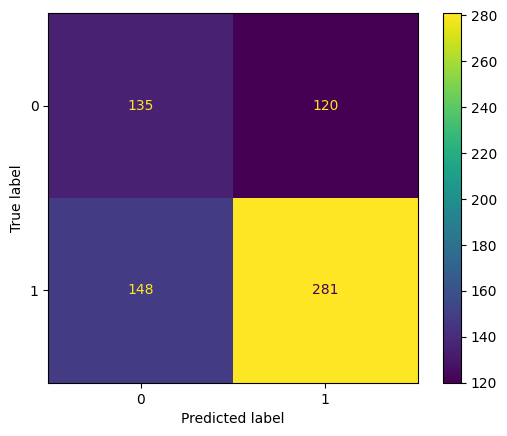

In [11]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
confusionmatrix = confusion_matrix(Y_test, actual)
cm_display = ConfusionMatrixDisplay(confusionmatrix, display_labels=[0,1])
cm_display.plot()

c:\Users\eddie\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
PermutationExplainer explainer: 301it [00:47,  6.29it/s]                         


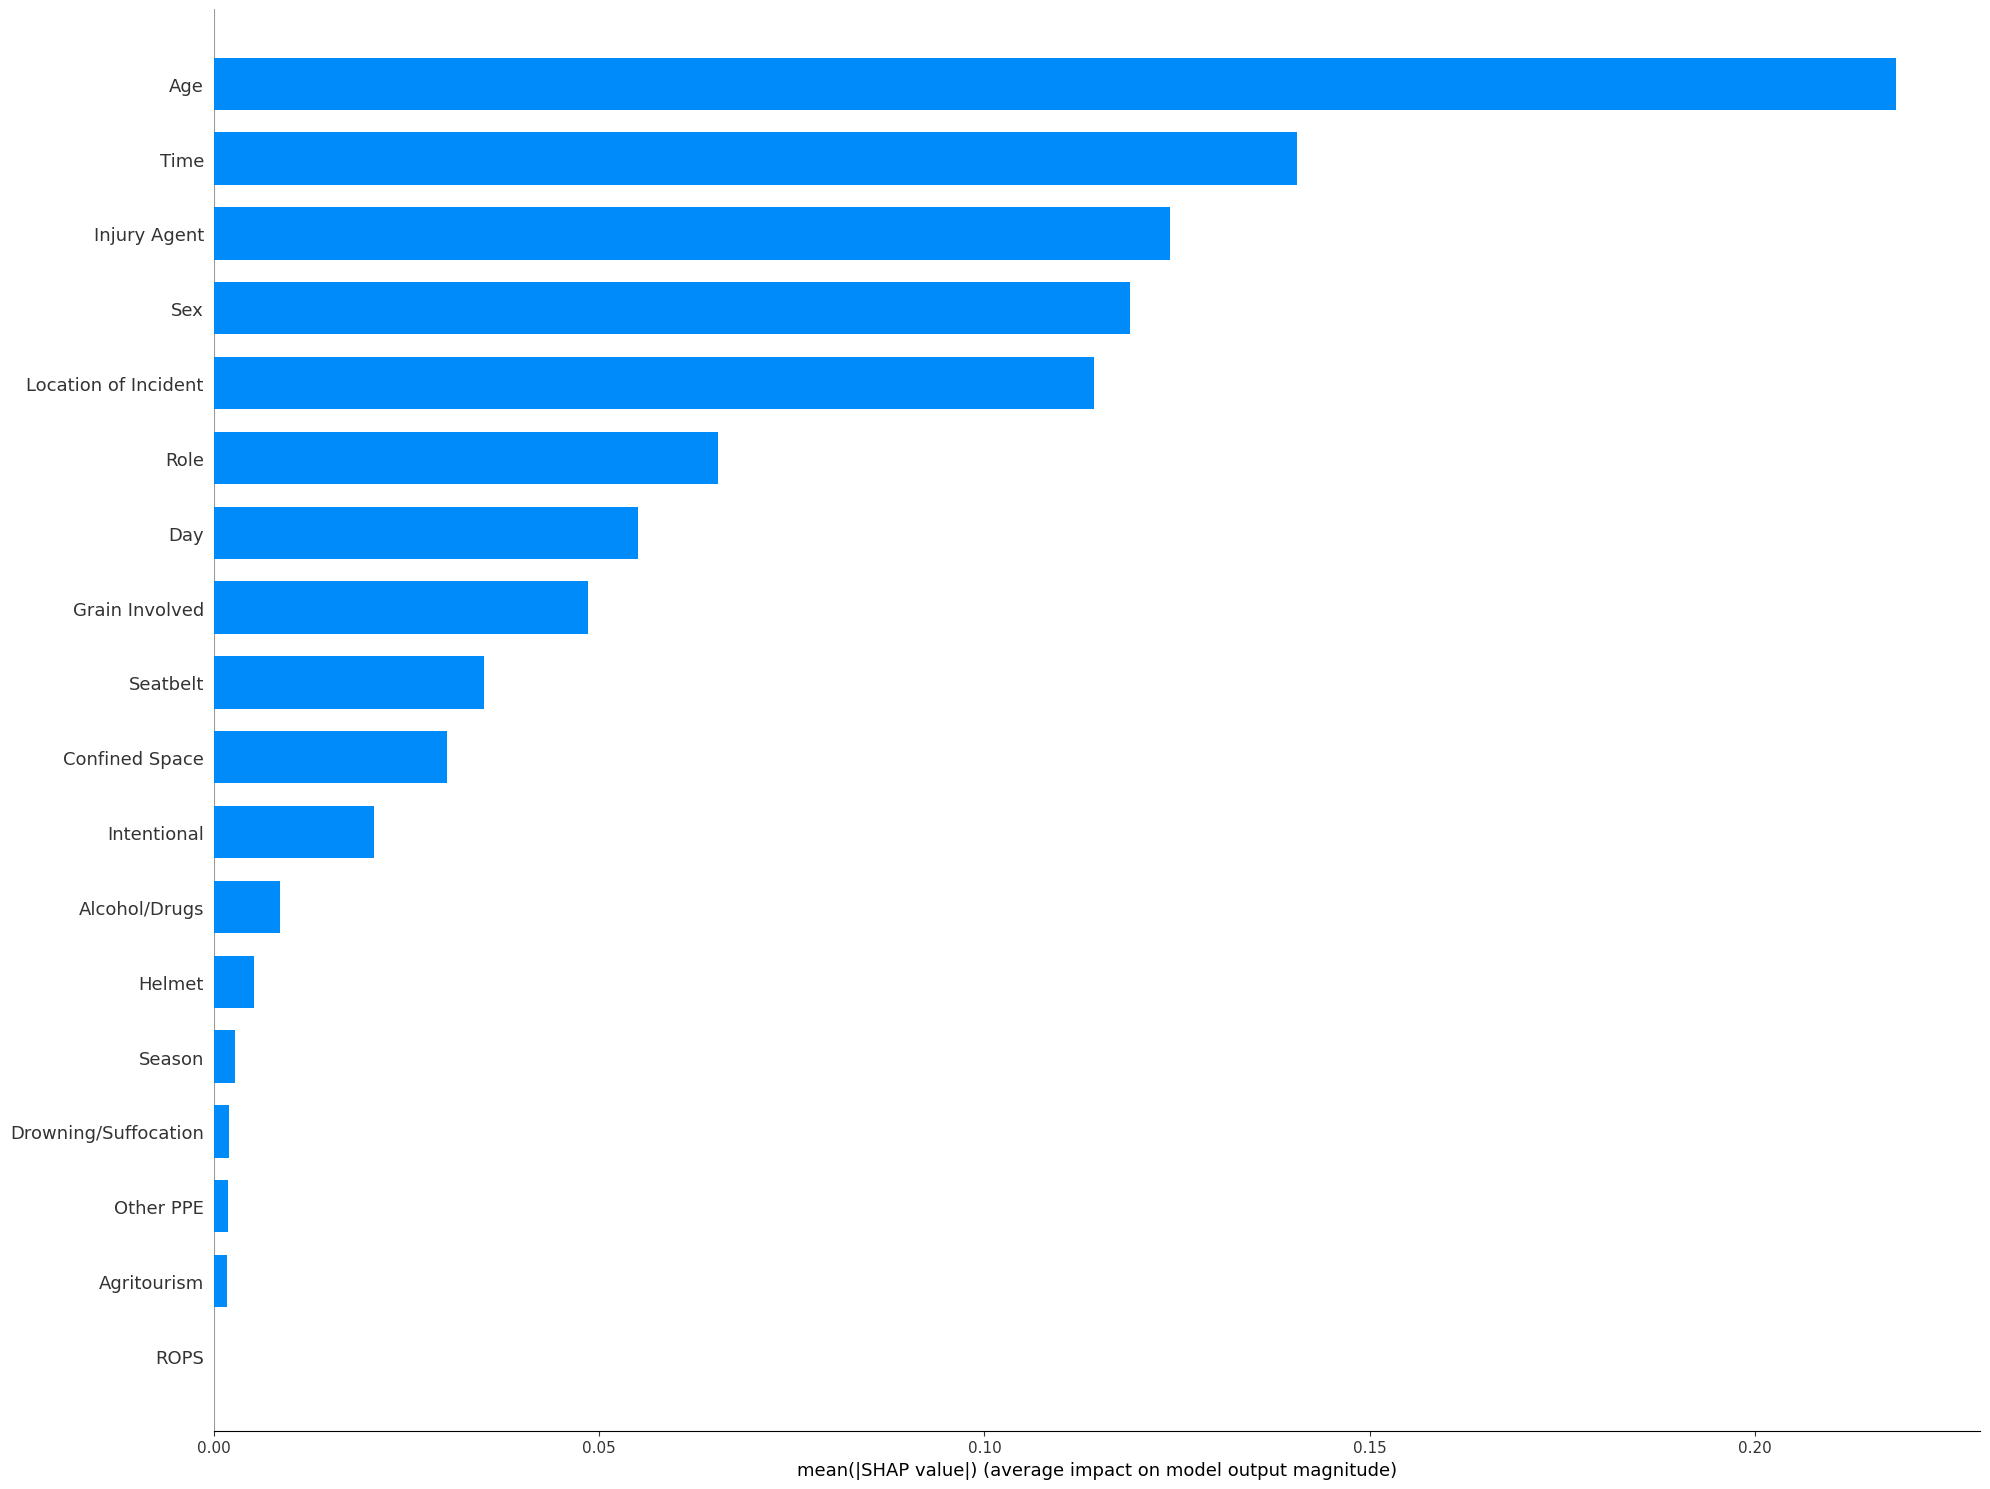

PermutationExplainer explainer: 301it [00:55,  4.51it/s]                         


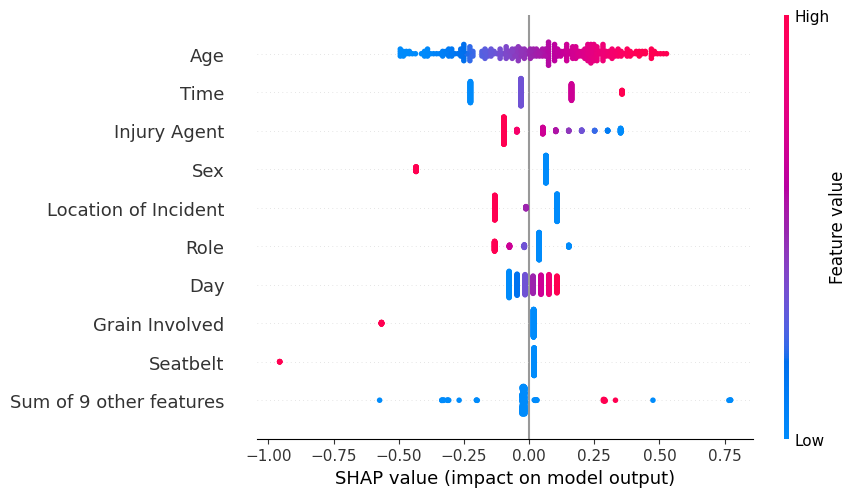

In [12]:
import shap
X_test_shap = shap.sample(X_train,nsamples = 300)
explainer = shap.Explainer(model, X_test_shap)
shap_values = explainer.shap_values(X_test_shap)
shap.summary_plot(shap_values, feature_names=features, plot_type="bar", plot_size=(20,15))
explanation = explainer(X_test_shap)
explanation = shap.Explanation(
    values=explanation, 
    feature_names=features
)
shap.plots.beeswarm(explanation)